# 📥🗃️ Load the Dataset

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [1]:

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Hyper-parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5
num_classes = 10

# 3. Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean & std for MNIST :contentReference[oaicite:1]{index=1}
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.41MB/s]


# ⚙️ Deep Learning Models

# 1️⃣ CNN

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        # input is (batch_size, in_channels, H, W) with H = W = 28
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1) #(batch_size, 32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # (batch_size, (32 or 64), H/2, W/2)
        # Flatten layer
        self.flatten = nn.Flatten() # (batch_size, 64 * (H/2) * (W/2))
        # d
        self.dropout = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

# 2️⃣ RNN

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_classes=10, bidirectional=False, batch_first=True):
        super(RNN, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size,
                           batch_first=True, bidirectional=bidirectional)

        hidden_size = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 28, 28) -> (batch, 28, 28)
        x = x.squeeze(1)

        # RNN expects (batch, seq_len, input_size)
        out, _ = self.rnn(x)

        # Take the last time step
        if self.bidirectional:
                # split forward and backward
                forward_out = out[:, :, :self.hidden_size]   # (B, W, hidden_size)
                backward_out = out[:, :, self.hidden_size:]  # (B, W, hidden_size)
                # forward last
                forward_last = forward_out[:, -1, :]        # (B, hidden_size)
                # backward last (which is backward after reading first token in forward sequence)
                # backward “last” effectively means backward_out[:, 0, :]
                backward_last = backward_out[:, 0, :]        # (B, hidden_size)
                out = torch.cat((forward_last, backward_last), dim=-1) # # (B, hidden_size * directions)
        else:
             out = out[:, -1, :]

        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

# 3️⃣ LSTM

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_classes=10, bidirectional=False, batch_first=True):
        super(LSTM, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size,
                           batch_first=True, bidirectional=bidirectional)

        hidden_size = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 28, 28) -> (batch, 28, 28)
        x = x.squeeze(1)

        # LSTM expects (batch, seq_len, input_size)
        out, _ = self.lstm(x)

        # Take the last time step
        if self.bidirectional:
                # split forward and backward
                forward_out = out[:, :, :self.hidden_size]   # (B, W, hidden_size)
                backward_out = out[:, :, self.hidden_size:]  # (B, W, hidden_size)
                # forward last
                forward_last = forward_out[:, -1, :]        # (B, hidden_size)
                # backward last (which is backward after reading first token in forward sequence)
                # backward “last” effectively means backward_out[:, 0, :]
                backward_last = backward_out[:, 0, :]        # (B, hidden_size)
                out = torch.cat((forward_last, backward_last), dim=-1) # # (B, hidden_size * directions)
        else:
             out = out[:, -1, :]

        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

# 4️⃣ GRU

In [4]:
class GRU(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_classes=10, bidirectional=False, batch_first=True):
        super(GRU, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size,
                           batch_first=True, bidirectional=bidirectional)

        hidden_size = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 28, 28) -> (batch, 28, 28)
        x = x.squeeze(1)

        # GRU expects (batch, seq_len, input_size)
        out, _ = self.gru(x)

        # Take the last time step
        if self.bidirectional:
                # split forward and backward
                forward_out = out[:, :, :self.hidden_size]   # (B, W, hidden_size)
                backward_out = out[:, :, self.hidden_size:]  # (B, W, hidden_size)
                # forward last
                forward_last = forward_out[:, -1, :]        # (B, hidden_size)
                # backward last (which is backward after reading first token in forward sequence)
                # backward “last” effectively means backward_out[:, 0, :]
                backward_last = backward_out[:, 0, :]        # (B, hidden_size)
                out = torch.cat((forward_last, backward_last), dim=-1) # # (B, hidden_size * directions)
        else:
             out = out[:, -1, :]

        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

# 🏋 📊 Training and Evaluation

In [7]:
def train_model(model, train_loader, test_loader, device,
                num_epochs=10, lr=0.001, model_name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss':   [], 'test_acc':   [],
        'epoch_time': []
    }

    for epoch in tqdm(range(num_epochs)):
        epoch_start = time.time()
        model.train()
        correct = 0
        total   = 0
        running_loss = 0.0
        pbar = tqdm(train_loader, total=len(train_loader))
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc  = correct / total

        # testing
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total   = 0
        with torch.no_grad():
            pbar = tqdm(test_loader, total=len(test_loader))
            for images, labels in pbar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss    = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total   += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss = test_loss / test_total
        test_acc  = test_correct / test_total
        epoch_time = time.time() - epoch_start

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['epoch_time'].append(epoch_time)

        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} — "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"Test loss: {test_loss:.4f}, acc: {test_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

    # Save model
    os.makedirs('saved_models', exist_ok=True)
    torch.save(model.state_dict(), f"saved_models/{model_name}.pth")
    # Save history
    torch.save(history, f"saved_models/{model_name}_history.pth")
    return model, history

def plot_history(history, model_name="model"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['test_loss'],   label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['test_acc'],   label='Test Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_plot.png")
    plt.show()

# 🔄 Training loop

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[CNN] Epoch 1/5 — Train loss: 0.2168, acc: 0.9337 | Test loss: 0.0455, acc: 0.9840 | Time: 106.86s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[CNN] Epoch 2/5 — Train loss: 0.0788, acc: 0.9763 | Test loss: 0.0383, acc: 0.9867 | Time: 107.85s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[CNN] Epoch 3/5 — Train loss: 0.0613, acc: 0.9815 | Test loss: 0.0299, acc: 0.9900 | Time: 105.94s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[CNN] Epoch 4/5 — Train loss: 0.0485, acc: 0.9855 | Test loss: 0.0276, acc: 0.9909 | Time: 103.08s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[CNN] Epoch 5/5 — Train loss: 0.0440, acc: 0.9865 | Test loss: 0.0253, acc: 0.9927 | Time: 102.95s


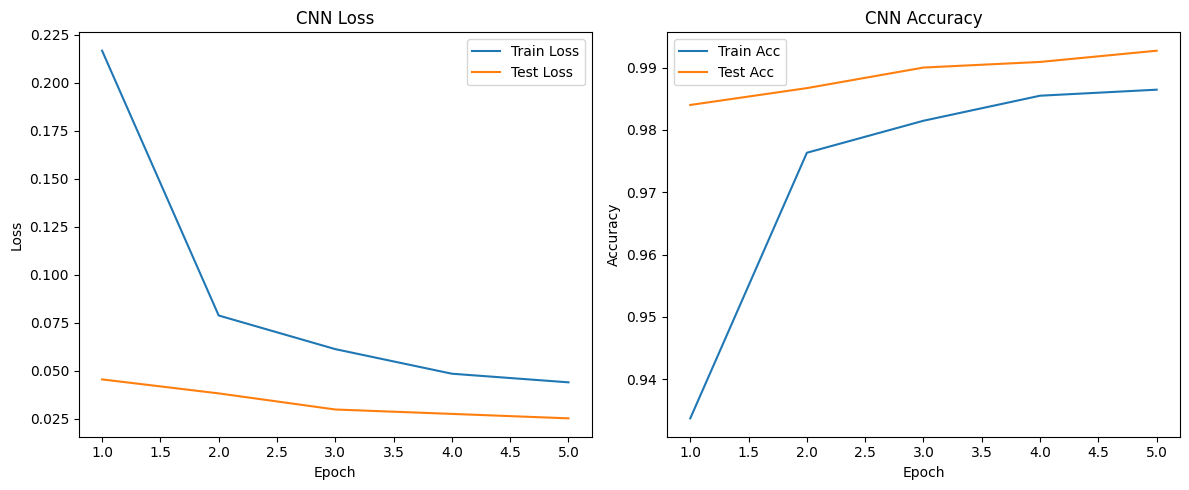

In [8]:
    # Train CNN
    cnn_model, cnn_hist = train_model(CNN(), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="CNN")
    plot_history(cnn_hist, model_name="CNN")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[RNN] Epoch 1/5 — Train loss: 0.6625, acc: 0.7846 | Test loss: 0.2837, acc: 0.9209 | Time: 34.27s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[RNN] Epoch 2/5 — Train loss: 0.2591, acc: 0.9260 | Test loss: 0.1796, acc: 0.9501 | Time: 33.77s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[RNN] Epoch 3/5 — Train loss: 0.1939, acc: 0.9453 | Test loss: 0.1939, acc: 0.9489 | Time: 34.53s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[RNN] Epoch 4/5 — Train loss: 0.1600, acc: 0.9552 | Test loss: 0.1896, acc: 0.9456 | Time: 33.14s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[RNN] Epoch 5/5 — Train loss: 0.1414, acc: 0.9611 | Test loss: 0.1577, acc: 0.9610 | Time: 33.06s


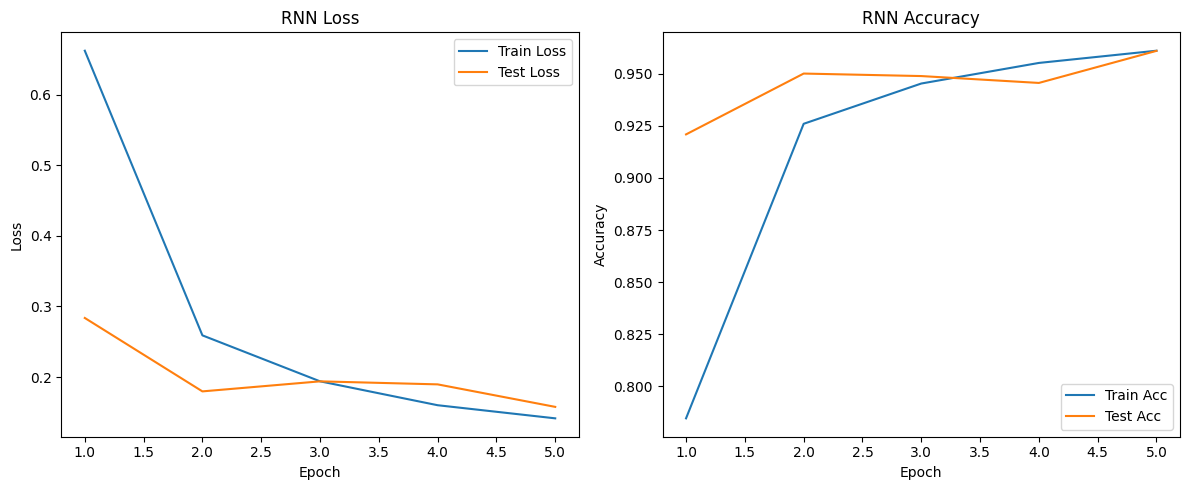

In [9]:
    # Train RNN
    rnn_model, rnn_hist = train_model(RNN(), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="RNN")
    plot_history(rnn_hist, model_name="RNN")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[LSTM] Epoch 1/5 — Train loss: 0.3730, acc: 0.8795 | Test loss: 0.1134, acc: 0.9667 | Time: 58.64s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[LSTM] Epoch 2/5 — Train loss: 0.0990, acc: 0.9719 | Test loss: 0.0758, acc: 0.9777 | Time: 58.45s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[LSTM] Epoch 3/5 — Train loss: 0.0704, acc: 0.9792 | Test loss: 0.0719, acc: 0.9786 | Time: 57.59s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[LSTM] Epoch 4/5 — Train loss: 0.0536, acc: 0.9840 | Test loss: 0.0612, acc: 0.9812 | Time: 58.01s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[LSTM] Epoch 5/5 — Train loss: 0.0440, acc: 0.9870 | Test loss: 0.0558, acc: 0.9839 | Time: 57.34s


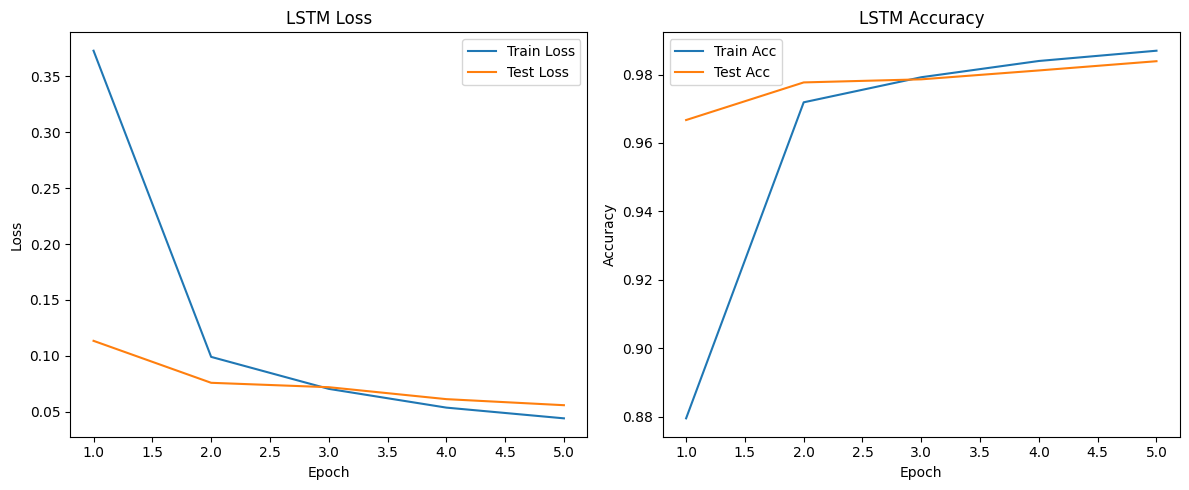

In [10]:
    # Train LSTM
    lstm_model, lstm_hist = train_model(LSTM(), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="LSTM")
    plot_history(lstm_hist, model_name="LSTM")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[GRU] Epoch 1/5 — Train loss: 0.4028, acc: 0.8719 | Test loss: 0.1029, acc: 0.9707 | Time: 54.81s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[GRU] Epoch 2/5 — Train loss: 0.0934, acc: 0.9722 | Test loss: 0.0669, acc: 0.9805 | Time: 54.62s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[GRU] Epoch 3/5 — Train loss: 0.0617, acc: 0.9811 | Test loss: 0.0636, acc: 0.9820 | Time: 54.23s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[GRU] Epoch 4/5 — Train loss: 0.0461, acc: 0.9864 | Test loss: 0.0713, acc: 0.9808 | Time: 53.85s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[GRU] Epoch 5/5 — Train loss: 0.0383, acc: 0.9881 | Test loss: 0.0492, acc: 0.9863 | Time: 54.23s


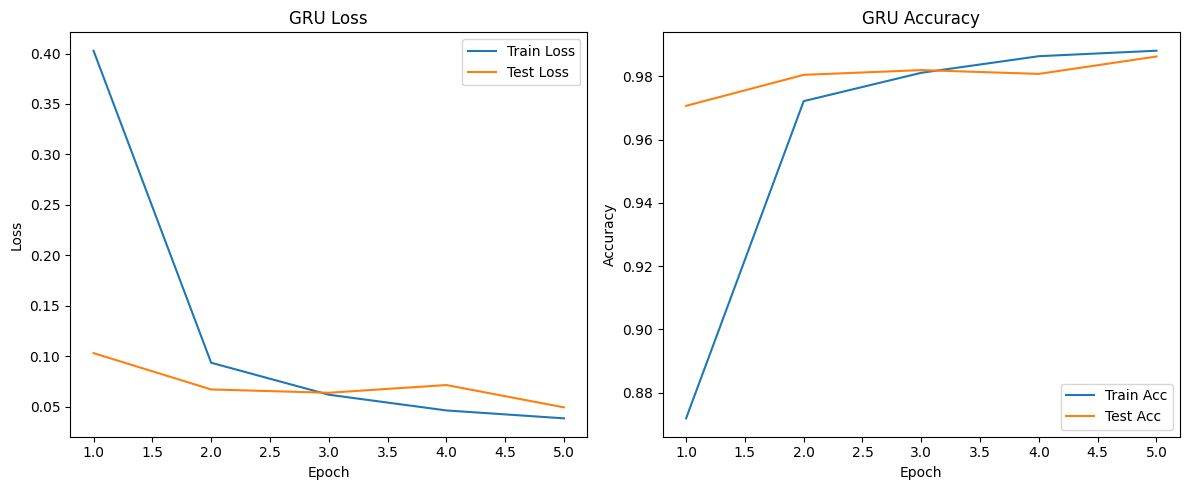

In [11]:
    # Train GRU
    gru_model, gru_hist = train_model(GRU(), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="GRU")
    plot_history(gru_hist, model_name="GRU")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiRNN] Epoch 1/5 — Train loss: 0.5339, acc: 0.8338 | Test loss: 0.1936, acc: 0.9443 | Time: 50.60s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiRNN] Epoch 2/5 — Train loss: 0.1850, acc: 0.9460 | Test loss: 0.1598, acc: 0.9513 | Time: 49.37s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiRNN] Epoch 3/5 — Train loss: 0.1369, acc: 0.9597 | Test loss: 0.1149, acc: 0.9671 | Time: 49.99s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiRNN] Epoch 4/5 — Train loss: 0.1184, acc: 0.9642 | Test loss: 0.1474, acc: 0.9571 | Time: 49.50s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiRNN] Epoch 5/5 — Train loss: 0.1027, acc: 0.9688 | Test loss: 0.0984, acc: 0.9695 | Time: 49.40s


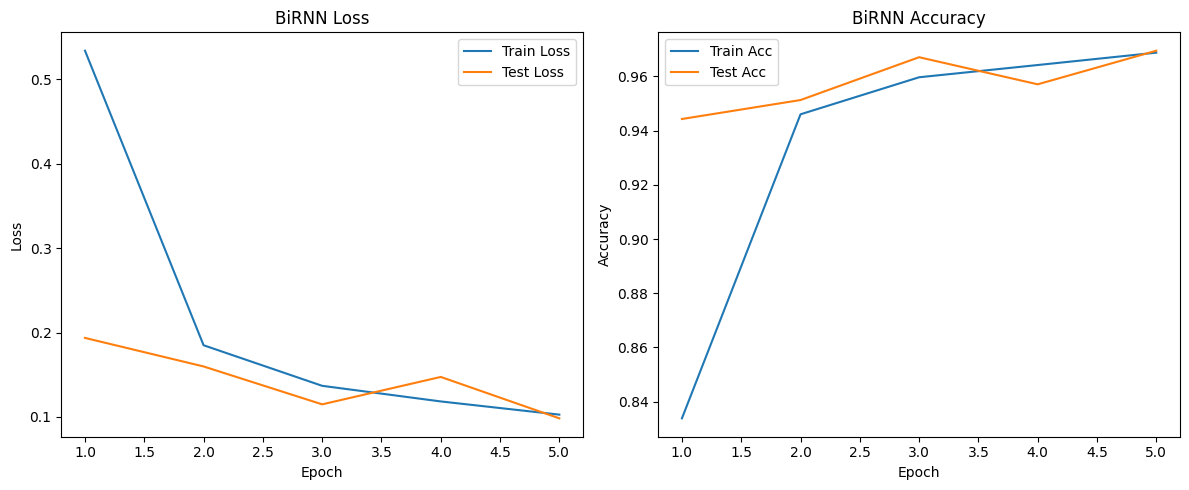

In [12]:
    # Train BiRNN
    birnn_model, birnn_hist = train_model(RNN(bidirectional=True), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="BiRNN")
    plot_history(birnn_hist, model_name="BiRNN")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiLSTM] Epoch 1/5 — Train loss: 0.2889, acc: 0.9101 | Test loss: 0.1023, acc: 0.9680 | Time: 111.76s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiLSTM] Epoch 2/5 — Train loss: 0.0798, acc: 0.9765 | Test loss: 0.0711, acc: 0.9794 | Time: 110.62s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiLSTM] Epoch 3/5 — Train loss: 0.0549, acc: 0.9832 | Test loss: 0.0658, acc: 0.9791 | Time: 111.89s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiLSTM] Epoch 4/5 — Train loss: 0.0460, acc: 0.9863 | Test loss: 0.0429, acc: 0.9870 | Time: 114.32s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiLSTM] Epoch 5/5 — Train loss: 0.0351, acc: 0.9889 | Test loss: 0.0457, acc: 0.9860 | Time: 118.93s


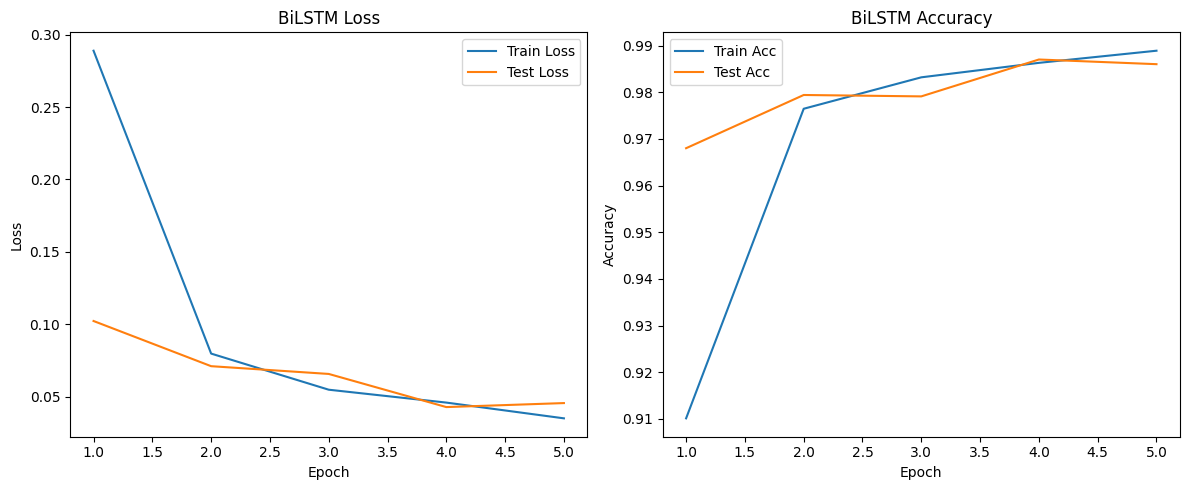

In [13]:
    # Train BiLSTM
    bilstm_model, bilstm_hist = train_model(LSTM(bidirectional=True), train_loader, test_loader, device,
                                      num_epochs=5, lr=learning_rate, model_name="BiLSTM")
    plot_history(bilstm_hist, model_name="BiLSTM")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiGRU] Epoch 1/5 — Train loss: 0.2968, acc: 0.9033 | Test loss: 0.0676, acc: 0.9801 | Time: 93.32s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiGRU] Epoch 2/5 — Train loss: 0.0662, acc: 0.9798 | Test loss: 0.0541, acc: 0.9816 | Time: 92.20s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiGRU] Epoch 3/5 — Train loss: 0.0470, acc: 0.9862 | Test loss: 0.0433, acc: 0.9874 | Time: 92.49s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiGRU] Epoch 4/5 — Train loss: 0.0343, acc: 0.9892 | Test loss: 0.0369, acc: 0.9885 | Time: 94.57s


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[BiGRU] Epoch 5/5 — Train loss: 0.0274, acc: 0.9912 | Test loss: 0.0431, acc: 0.9861 | Time: 93.71s


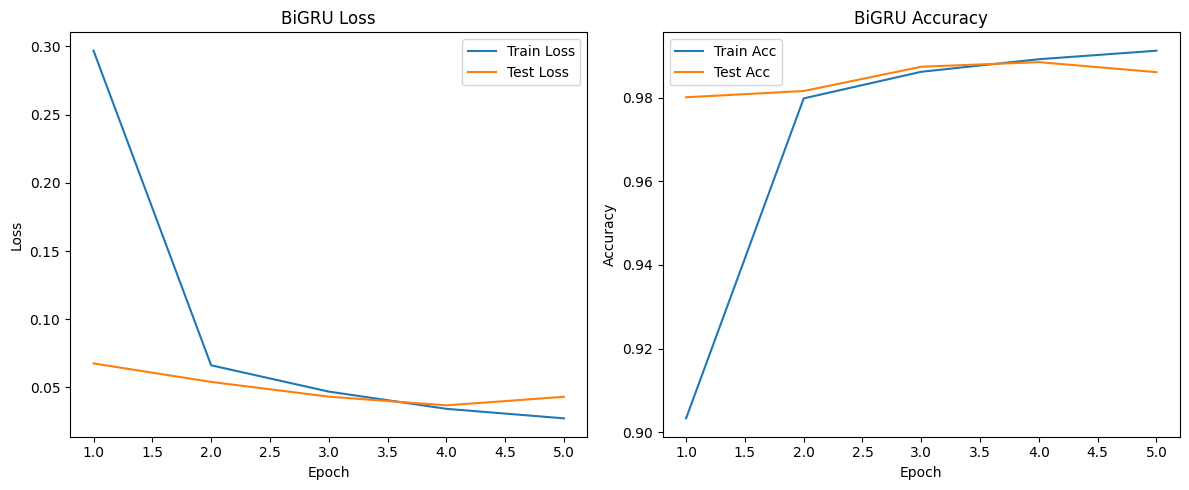

In [17]:
    # Train BiGRU
    bigru_model, bigru_hist = train_model(GRU(bidirectional=True), train_loader, test_loader, device,
                                      num_epochs=num_epochs, lr=learning_rate, model_name="BiGRU")
    plot_history(bigru_hist, model_name="BiGRU")